In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.optimize import minimize
from scipy.stats import erlang
import pandas as pd

np.random.seed(42)

In [22]:
# Parámetros del problema
S0 = 19.9
K = 60
l = 3

PI_I = 0.4
PI_L = 0.6

### **Price Distribution**

$$
P \sim \text{Erlang}(K = 60,\ \lambda = 3)
$$

In [23]:
# PDF de erlang con librería scipy
f = lambda p: erlang.pdf(p, K, scale=1/l)

### **Liquidity Trading Behavior**

In [24]:
def pi_LB(s):
    prob = 0.5 - 0.08*s
    return prob if prob > 0 else 0

def pi_LS(s):
    prob = 0.5 - 0.08*s
    return prob if prob > 0 else 0

def right(A):
    val, _ = quad(lambda p: (p - A) * f(p), A, np.inf)
    return val

def left(B):
    val, _ = quad(lambda p: (B - p) * f(p), 0, B)
    return val

def obj(x):
    bid, ask = x

    u_sell = pi_LB(ask - S0) * (ask - S0)
    u_buy  = pi_LS(S0 - bid) * (S0 - bid)
    u_total = PI_L * (u_sell + u_buy)

    loss_buy = right(ask)
    loss_sell = left(bid)
    loss_total = PI_I * (loss_buy + loss_sell)

    pnl = u_total - loss_total
    return -pnl

In [25]:
bnds = [(0, S0), (S0, np.inf)]

res = minimize(
    obj,
    x0 = [15, 20],
    bounds = bnds
)

opt_bid, opt_ask = res.x
profit_per_trade = -res.fun

### **Expected Revenue Analysis (from Copeland and Galai's paper)**

In [26]:
print(f"Profit per Trade: {profit_per_trade:.2f}")

Profit per Trade: 0.84


### **Optimal Bid-Ask Quotes**

In [27]:
print(f"Optimal Bid: {opt_bid:.2f}")
print(f"Optimal Ask: {opt_ask:.2f}")

Optimal Bid: 16.45
Optimal Ask: 23.43


### **Market Simulation**

- Simulate 10,000 trades
- Track cumulative P&L over time, inventory position and individual trade P&L
- Compare 3 different strategies:
    - Optimal Quotes
    - Tight spreads ($B = 19.75, A = 20.25$)
    - Wide Spreads ($B = 18.40, A = 21.40$)

In [28]:
def simulate_trade(B, A, S0, PI_I, PI_L):
    it = 0
    buy = 0
    while True:
        i_l = np.random.rand()
        p = erlang.rvs(K, scale=1/l)
        if np.random.rand() < 0.5:
            # Buy
            if i_l < PI_I:
                # Informado
                if p > A:
                    pl = -(p - A)
                    inv = -1
                    it += 1
                    buy += 1
                else:
                    continue
            else:
                # Liquidez
                if PI_L > pi_LB(A - S0):
                    pl = A - S0
                    inv = -1
                    buy += 1
                else:
                    continue

        else:
            # Sell
            if i_l < PI_I:
                # Informado
                if p < B:
                    pl = -(B - p)
                    inv = 1
                    it += 1
                else:
                    continue
            else:
                # Liquidez
                if PI_L > pi_LS(S0 - B):
                    pl = S0 - B
                    inv = 1
                else:
                    continue

        return pl, inv, it, buy
    
def scenario(num_trades, B, A, S0, PI_I, PI_L):
    history = pd.DataFrame(columns=['P&L', 'Inventory', 'Informed', 'Buy'])

    for i in range(num_trades):
        pl, inv, it, buy = simulate_trade(B, A, S0, PI_I, PI_L)

        history.loc[i] = [pl, inv, it, buy]
        
    return history

In [29]:
tight_bid, tight_ask = 19.75, 20.05
wide_bid, wide_ask = 18.40, 21.40

op_history = scenario(10000, opt_bid, opt_ask, S0, PI_I, PI_L)
tight_history= scenario(10000, tight_bid, tight_ask, S0, PI_I, PI_L)
wide_history= scenario(10000, wide_bid, wide_ask, S0, PI_I, PI_L)

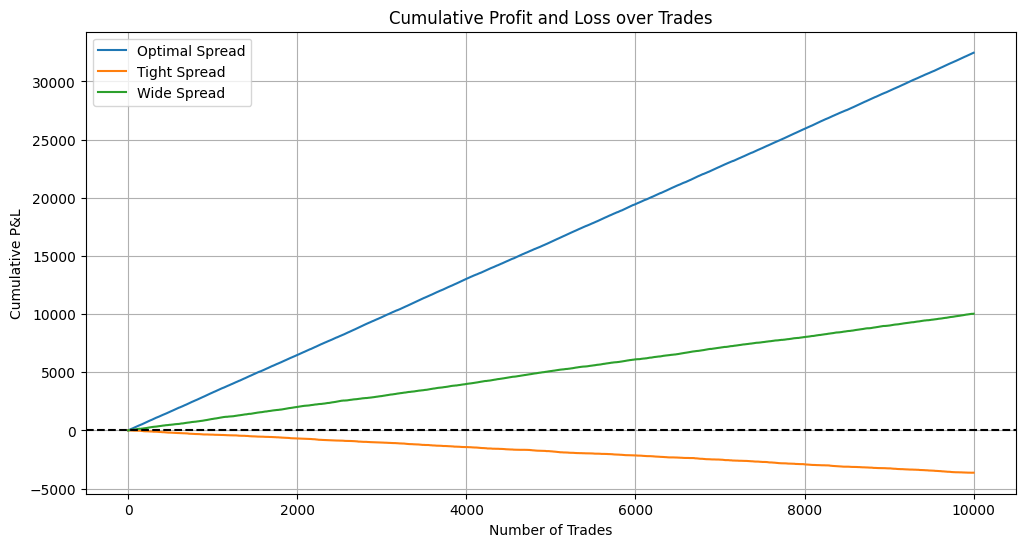

In [30]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(op_history['P&L']), label='Optimal Spread')
plt.plot(np.cumsum(tight_history['P&L']), label='Tight Spread')
plt.plot(np.cumsum(wide_history['P&L']), label='Wide Spread')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Cumulative Profit and Loss over Trades')
plt.xlabel('Number of Trades')
plt.ylabel('Cumulative P&L')
plt.legend()
plt.grid()
plt.show()

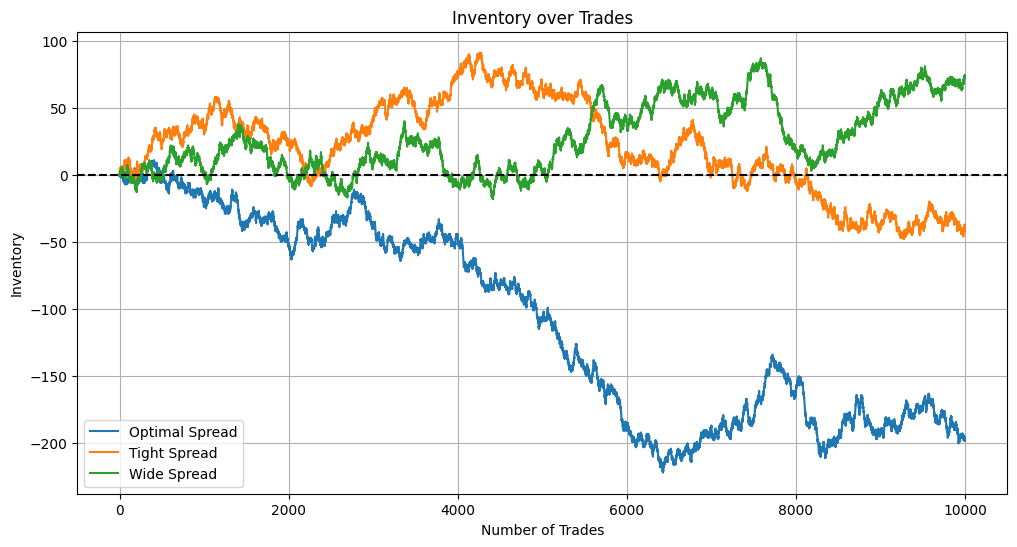

In [31]:
plt.figure(figsize=(12, 6))
plt.plot(np.cumsum(op_history['Inventory']), label='Optimal Spread')
plt.plot(np.cumsum(tight_history['Inventory']), label='Tight Spread')
plt.plot(np.cumsum(wide_history['Inventory']), label='Wide Spread')
plt.axhline(y=0, color='black', linestyle='--')
plt.title('Inventory over Trades')
plt.xlabel('Number of Trades')
plt.ylabel('Inventory')
plt.legend()
plt.grid()
plt.show()

### **Adverse Selection Analysis**
- Informed vs Uninformed trades, sells vs buys
- Average P&Ls, percentage of informed trades

In [32]:
results = pd.DataFrame(columns=['Optimal Spread', 'Tight Spread', 'Wide Spread'])

results.loc['Average P&L'] = [
    round(op_history['P&L'].mean(), 2),
    round(tight_history['P&L'].mean(), 2),
    round(wide_history['P&L'].mean(), 2)
]

results.loc['Final Inventory'] = [
    op_history['Inventory'].sum(),
    tight_history['Inventory'].sum(),
    wide_history['Inventory'].sum()
]

results.loc['% Informed Trades'] = [
    op_history['Informed'].mean() * 100,
    tight_history['Informed'].mean() * 100,
    wide_history['Informed'].mean() * 100
]

results.loc['% Buy Trades'] = [
    op_history['Buy'].mean() * 100,
    tight_history['Buy'].mean() * 100,
    wide_history['Buy'].mean() * 100
]

results

,Optimal Spread,Tight Spread,Wide Spread
Average P&L,3.25,-0.36,1.00
Final Inventory,-198.00,-42.00,74.00
% Informed Trades,5.16,24.01,15.69
% Buy Trades,50.99,50.21,49.63


In [33]:
op_history_mc = [(scenario(1000, opt_bid, opt_ask, S0, PI_I, PI_L))['P&L'].sum() for _ in range(1000)]
tight_history_mc = [(scenario(1000, tight_bid, tight_ask, S0, PI_I, PI_L))['P&L'].sum() for _ in range(1000)]
wide_history_mc = [(scenario(1000, wide_bid, wide_ask, S0, PI_I, PI_L))['P&L'].sum() for _ in range(1000)]

**Why do informed traders induce spreads?**


**How does the adverse selection cost change with spread width?**


**Other risks market makers face (from these results)**



### **Monte Carlo**
- Run 1000 simulations with 1000 trades for the 3 strategies
- Analyze the distribution of the outcomes, include statistics
- Probability of losing money over 1000 trades

In [34]:
gen_history = pd.DataFrame({
    'Optimal Spread': op_history_mc,
    'Tight Spread': tight_history_mc,
    'Wide Spread': wide_history_mc
})

gen_history.describe()

,Optimal Spread,Tight Spread,Wide Spread
count,1000.000000,1000.000000,1000.000000
mean,3230.412315,-369.168031,1010.651523
std,35.020671,39.727050,39.926319
min,3109.616399,-511.451184,875.230398
25%,3207.568104,-396.233968,983.063371
50%,3231.823003,-368.474536,1011.271978
75%,3255.423904,-342.037924,1036.590638
max,3332.358203,-240.139390,1135.296757


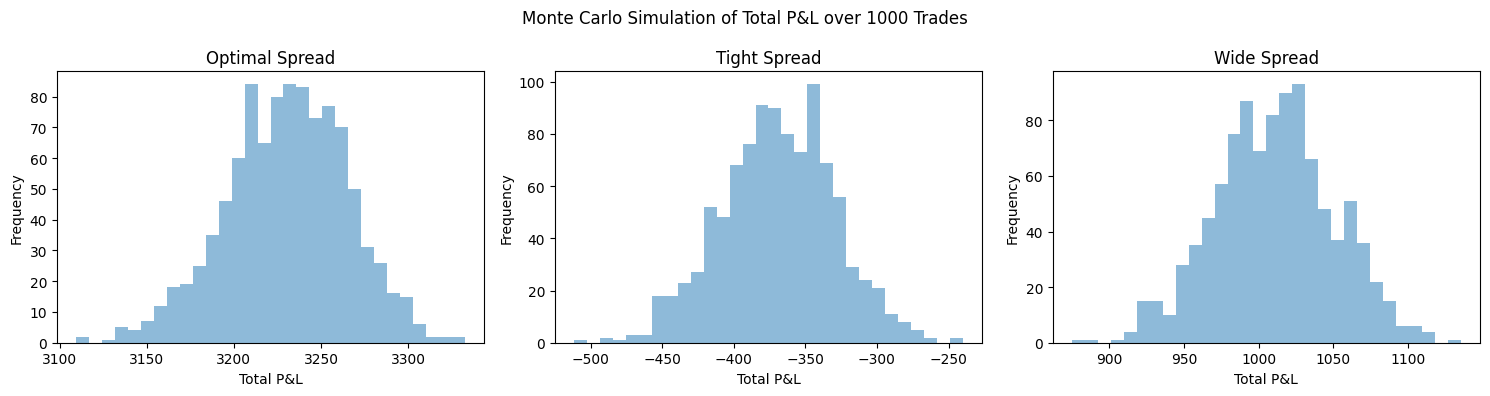

In [35]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
plt.suptitle('Monte Carlo Simulation of Total P&L over 1000 Trades')

axs[0].hist(op_history_mc, bins=30, alpha=0.5)
axs[0].set_title("Optimal Spread")
axs[0].set_xlabel('Total P&L')
axs[0].set_ylabel('Frequency')

axs[1].hist(tight_history_mc, bins=30, alpha=0.5)
axs[1].set_title("Tight Spread")
axs[1].set_xlabel('Total P&L')
axs[1].set_ylabel('Frequency')

axs[2].hist(wide_history_mc, bins=30, alpha=0.5)
axs[2].set_title("Wide Spread")
axs[2].set_xlabel('Total P&L')
axs[2].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [36]:
results_mc = pd.DataFrame(columns = ['Loss %'])

results_mc.loc['Optimal Spread'] = [sum(1 for x in op_history_mc if x < 0) / len(op_history_mc) * 100]
results_mc.loc['Tight Spread'] = [sum(1 for x in tight_history_mc if x < 0) / len(tight_history_mc) * 100]
results_mc.loc['Wide Spread'] = [sum(1 for x in wide_history_mc if x < 0) / len(wide_history_mc) * 100]

results_mc

,Loss %
Optimal Spread,0.0
Tight Spread,100.0
Wide Spread,0.0


### **Economic Insights**
Why do spreads exist?
Real world applications
Model limitations